In [2]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

In [3]:
from core.data_repository import DataRepository
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN_enhanced']




 2025-09-26 11:33:57 - data_repository - INFO - Loaded: AAPL
 2025-09-26 11:33:57 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-09-26 11:33:57 - data_repository - INFO - Loaded: IBM
 2025-09-26 11:33:57 - data_repository - INFO - Loaded: AMZN
 2025-09-26 11:33:57 - data_repository - INFO - Loaded periodic stock market data for: {'AAPL', 'AMZN', 'AMZN_enhanced', 'IBM'}


In [4]:
# fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
# tick_positions = np.linspace(0, len(AMZN_periodic_data.index) - 1, 4, dtype=int)

# # Plot Close
# sns.lineplot(ax=axes[0], data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Close', label='Close')
# axes[0].set_title('AMZN Closing Price')

# # RSI
# sns.lineplot(ax=axes[1], data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='RSI', label='RSI', color='orange')
# axes[1].set_title('RSI')

# # Bandwidth
# sns.lineplot(ax=axes[2], data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Bandwidth', label='Bandwidth', color='green')
# axes[2].set_title('Bollinger Bandwidth')

# # %B
# sns.lineplot(ax=axes[3], data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='%B', label='%B', color='purple')
# axes[3].set_title('Bollinger %B')


# for ax in axes:
#     ax.set_xticks(AMZN_periodic_data.index[tick_positions])
#     ax.legend()
#     ax.grid(True)

# plt.tight_layout()
# plt.show()

In [5]:
from core.data_preparator import DataPreparator
timesteps_lookback = 3
data_preparator = DataPreparator()
AMZN_supervised_data = data_preparator.reformat_periodic_to_supervised_data(dataframe=AMZN_periodic_data, target_column='Close', t=timesteps_lookback)
display(AMZN_supervised_data)
display(AMZN_periodic_data)

 2025-09-26 11:33:57 - data_preparator - INFO - Preparing data for target column: Close, with t=3
 2025-09-26 11:33:58 - data_preparator - INFO - Adding technical indicators to supervised data


,Close,Close_0,Close_1,Close_2,RSI,Bandwidth,%B
Date,,,,,,,
2022-02-03,138.845505,150.612503,151.193497,149.573502,29.931942,24.833632,0.141874
2022-02-04,157.639496,138.845505,150.612503,151.193497,53.155893,24.232240,0.649775
2022-02-07,157.935501,157.639496,138.845505,150.612503,53.417772,23.718960,0.667875
2022-02-08,161.413498,157.935501,157.639496,138.845505,56.495267,23.709387,0.764630
2022-02-09,161.189499,161.413498,157.935501,157.639496,56.237572,23.028714,0.772386
...,...,...,...,...,...,...,...
2025-09-05,232.330002,235.679993,225.990005,225.339996,56.526344,6.962863,0.798986
2025-09-08,235.839996,232.330002,235.679993,225.990005,60.031290,7.323344,0.954099
2025-09-09,238.240005,235.839996,232.330002,235.679993,62.271145,7.674673,1.020037


,Close,High,Low,Open,Volume,RSI,Bandwidth,%B
Date,,,,,,,,
2022-01-31,149.573502,150.360504,144.300507,144.750000,78308000,39.905046,26.412278,0.356150
2022-02-01,151.193497,151.707993,147.627502,150.000000,59220000,42.848523,25.132890,0.414336
2022-02-02,150.612503,155.074997,148.863495,155.050507,87330000,42.052984,24.118402,0.417377
2022-02-03,138.845505,144.247498,138.332993,141.737503,225532000,29.931942,24.833632,0.141874
2022-02-04,157.639496,161.199997,150.608002,155.606506,253456000,53.155893,24.232240,0.649775
...,...,...,...,...,...,...,...,...
2025-09-05,232.330002,236.000000,231.929993,235.190002,36721800,56.526344,6.962863,0.798986
2025-09-08,235.839996,237.600006,233.750000,234.940002,33947100,60.031290,7.323344,0.954099
2025-09-09,238.240005,238.850006,235.080002,236.360001,27033800,62.271145,7.674673,1.020037


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler_X_close = MinMaxScaler()
scaler_X_rsi = MinMaxScaler()
scaler_X_bandwidth = MinMaxScaler()
scaler_X_pb = MinMaxScaler()
scaler_y = MinMaxScaler()
target_column = 'Close'
feature_columns = [col for col in AMZN_supervised_data.columns if col != target_column]

feature_number = len(feature_columns)

feature_close = [col for col in feature_columns if 'Close' in col]
feature_rsi = [col for col in feature_columns if 'RSI' in col]
feature_bandwidth = [col for col in feature_columns if 'Bandwidth' in col]
feature_pb = [col for col in feature_columns if '%B' in col]

AMZN_supervised_data[feature_close] = scaler_X_close.fit_transform(AMZN_supervised_data[feature_close])
AMZN_supervised_data[feature_rsi] = scaler_X_rsi.fit_transform(AMZN_supervised_data[feature_rsi])
AMZN_supervised_data[feature_bandwidth] = scaler_X_bandwidth.fit_transform(AMZN_supervised_data[feature_bandwidth])
AMZN_supervised_data[feature_pb] = scaler_X_pb.fit_transform(AMZN_supervised_data[feature_pb])
AMZN_supervised_data[[target_column]] = scaler_y.fit_transform(AMZN_supervised_data[[target_column]])
display(AMZN_supervised_data)


,Close,Close_0,Close_1,Close_2,RSI,Bandwidth,%B
Date,,,,,,,
2022-02-03,0.355876,0.429309,0.432935,0.422825,0.145938,0.428902,0.265572
2022-02-04,0.473162,0.355876,0.429309,0.432935,0.570415,0.416660,0.577937
2022-02-07,0.475009,0.473162,0.355876,0.429309,0.575202,0.406212,0.589069
2022-02-08,0.496714,0.475009,0.473162,0.355876,0.631451,0.406017,0.648574
2022-02-09,0.495316,0.496714,0.475009,0.473162,0.626741,0.392162,0.653344
...,...,...,...,...,...,...,...
2025-09-05,0.939279,0.960185,0.899713,0.895657,0.632019,0.065129,0.669703
2025-09-08,0.961183,0.939279,0.960185,0.899713,0.696080,0.072467,0.765100
2025-09-09,0.976161,0.961183,0.939279,0.960185,0.737019,0.079619,0.805652


In [7]:
from core.dataset import StockDataset
from sklearn.model_selection import train_test_split
import pandas as pd

AMZN_train_dataset, AMZN_test_dataset = train_test_split(AMZN_supervised_data, test_size=.1, shuffle=False, random_state=42)
AMZN_train_dataset, AMZN_validation_dataset = train_test_split(AMZN_train_dataset, test_size=.2, shuffle=False, random_state=42)

In [8]:
AMZN_train_dataset = StockDataset(AMZN_train_dataset, ticker='AMZN_ENHANCED')
AMZN_validation_dataset = StockDataset(AMZN_validation_dataset, ticker='AMZN_ENHANCED')
AMZN_test_dataset = StockDataset(AMZN_test_dataset, ticker='AMZN_ENHANCED')

 2025-09-26 11:34:00 - dataset - INFO - Created stock dataset for AMZN_ENHANCED, focusing target: Close
 2025-09-26 11:34:00 - dataset - INFO - Created stock dataset for AMZN_ENHANCED, focusing target: Close
 2025-09-26 11:34:00 - dataset - INFO - Created stock dataset for AMZN_ENHANCED, focusing target: Close


In [9]:
from torch.utils.data import DataLoader
AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)

In [10]:
for X_batch, y_batch in AMZN_train_data_loader:
    print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')
    print(f'X_batch: {X_batch}, y_batch: {y_batch}')
    break

X_batch shape: torch.Size([16, 6]), y_batch shape: torch.Size([16])
X_batch: tensor([[0.4293, 0.4329, 0.4228, 0.1459, 0.4289, 0.2656],
        [0.3559, 0.4293, 0.4329, 0.5704, 0.4167, 0.5779],
        [0.4732, 0.3559, 0.4293, 0.5752, 0.4062, 0.5891],
        [0.4750, 0.4732, 0.3559, 0.6315, 0.4060, 0.6486],
        [0.4967, 0.4750, 0.4732, 0.6267, 0.3922, 0.6533],
        [0.4953, 0.4967, 0.4750, 0.5797, 0.3724, 0.6265],
        [0.4817, 0.4953, 0.4967, 0.4679, 0.3578, 0.5302],
        [0.4460, 0.4817, 0.4953, 0.5050, 0.3400, 0.5765],
        [0.4577, 0.4460, 0.4817, 0.5318, 0.3342, 0.6075],
        [0.4661, 0.4577, 0.4460, 0.5637, 0.3382, 0.6363],
        [0.4760, 0.4661, 0.4577, 0.4895, 0.3404, 0.5637],
        [0.4545, 0.4760, 0.4661, 0.4477, 0.3272, 0.5138],
        [0.4417, 0.4545, 0.4760, 0.4001, 0.3182, 0.4581],
        [0.4267, 0.4417, 0.4545, 0.3051, 0.3009, 0.3343],
        [0.3932, 0.4267, 0.4417, 0.4559, 0.2648, 0.4611],
        [0.4340, 0.3932, 0.4267, 0.5056, 0.2257, 0.50

In [ ]:
from models.lstm_model import LSTMStockModel

lstm_enhanced_model = LSTMStockModel(
    id='base_amzn_model',
    ticker='AMZN',
    input_dim=1,
    hidden_dim=64,
    layer_dim=1,
    output_dim=1
)

 2025-09-26 11:34:00 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=64,
layer_dimension=1,
output_dimension=1)


In [12]:
from torch.optim import Adam
from torch.nn import MSELoss

optimizer = Adam(AMZN_base_model.parameters(), lr=0.001)
loss_function = MSELoss()

In [13]:
from torch.utils.data import DataLoader
import torch
import numpy as np


AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=10, shuffle=False)


train_rmse_list = []
val_rmse_list = []

predictions = []
actuals = []
epochs = 20

for epoch in range(epochs):
    # Training loop
    AMZN_base_model.train()
    train_loss = 0
    for X,y in AMZN_train_data_loader:
        optimizer.zero_grad()
        X, y = X.reshape(-1,feature_number,1), y.reshape(-1,1) # Adjust for t
        outputs, _ = AMZN_base_model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions.extend(outputs.detach().numpy().flatten())
        actuals.extend(y.numpy().flatten())
        
    # Validation loop
    AMZN_base_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X,y in AMZN_validation_data_loader:
            X, y = X.reshape(-1,feature_number,1), y.reshape(-1,1)
            outputs, _ = AMZN_base_model(X)
            val_loss += loss_function(outputs, y).item()
            
    train_rmse = np.sqrt(train_loss / len(AMZN_train_data_loader))
    val_rmse = np.sqrt(val_loss / len(AMZN_validation_data_loader))
    
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
        
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'RMSE: {train_rmse:.4f}')
    print(f'Validation RMSE: {val_rmse:.4f}')

Epoch [1/20]
RMSE: 0.2117
Validation RMSE: 0.2747
Epoch [2/20]
RMSE: 0.2749
Validation RMSE: 0.4981
Epoch [3/20]
RMSE: 0.2098
Validation RMSE: 0.4205
Epoch [4/20]
RMSE: 0.2257
Validation RMSE: 0.4394
Epoch [5/20]
RMSE: 0.2163
Validation RMSE: 0.4277
Epoch [6/20]
RMSE: 0.2165
Validation RMSE: 0.4258
Epoch [7/20]
RMSE: 0.2131
Validation RMSE: 0.4172
Epoch [8/20]
RMSE: 0.2097
Validation RMSE: 0.4024
Epoch [9/20]
RMSE: 0.2019
Validation RMSE: 0.3571
Epoch [10/20]
RMSE: 0.1820
Validation RMSE: 0.2062
Epoch [11/20]
RMSE: 0.1292
Validation RMSE: 0.0560
Epoch [12/20]
RMSE: 0.0934
Validation RMSE: 0.0549
Epoch [13/20]
RMSE: 0.0542
Validation RMSE: 0.0626
Epoch [14/20]
RMSE: 0.0376
Validation RMSE: 0.0698
Epoch [15/20]
RMSE: 0.0305
Validation RMSE: 0.0729
Epoch [16/20]
RMSE: 0.0280
Validation RMSE: 0.0728
Epoch [17/20]
RMSE: 0.0270
Validation RMSE: 0.0715
Epoch [18/20]
RMSE: 0.0268
Validation RMSE: 0.0700
Epoch [19/20]
RMSE: 0.0274
Validation RMSE: 0.0682
Epoch [20/20]
RMSE: 0.0292
Validation RM

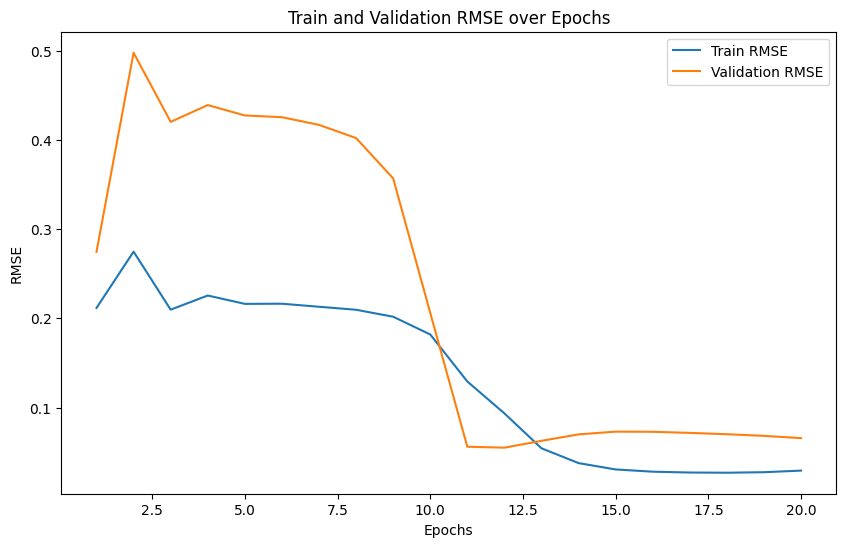

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs_range, y=train_rmse_list, label='Train RMSE')
sns.lineplot(x=epochs_range, y=val_rmse_list, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train and Validation RMSE over Epochs')
plt.legend()
plt.show()

In [ ]:
AMZN_base_model.eval()
AMZN_test_data_loader = DataLoader(AMZN_test_dataset, batch_size=10, shuffle=False)
test_loss = 0

predictions = []
actuals = []

with torch.no_grad():
    for X,y in AMZN_test_data_loader:
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
        outputs, _ = AMZN_base_model(X)
        test_loss += loss_function(outputs, y).item()
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(y.numpy().flatten())

test_rmse = np.sqrt(test_loss / len(AMZN_test_data_loader))
print(f'Test RMSE: {test_rmse:.4f}')